In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from scipy.special import eval_chebyu
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from SimBiquad_Hugo import SimBiquad as Biquad_Hugo

# Simulation

## Testing

In [2]:
b, a = signal.iirnotch(350, 5, 3000)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs(mag, angle, samp_per_clock=8)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=int)
coeffs_returned = np.zeros(len(coeffs), dtype=float)
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point[i] = convert_to_fixed_point(coeffs[i], 4, 14)
    coeffs_returned[i] = convert_from_fixed_point(coeffs_fixed_point[i], 4, 14)
print(coeffs_fixed_point)
print(coeffs_returned-coeffs)

[ 16384  22685  17268   4328 253231 246067  16384  22685  17268   4328
 253231 246067 247577  12573 255851   5431   3861   7563 255832   5448
 260968]
[ 0.00000000e+00 -2.77119487e-05 -1.35697666e-05 -1.21258016e-05
 -2.06598028e-05 -2.66608329e-05  0.00000000e+00 -2.77119487e-05
 -1.35697666e-05 -1.21258016e-05 -2.06598028e-05 -2.66608329e-05
 -2.61942259e-05 -3.21446595e-05 -5.45704005e-05 -1.22153697e-05
 -2.51724677e-05 -2.86627468e-05 -2.02302620e-05 -5.25786464e-06
 -1.64039319e-05]


## Run Simulation

In [3]:
data = import_data("CaptureData/capture_240822_A_0_B_1_impulse_X1_16384_f_after.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]
print(input0_offset)
input0 = input0[input0_offset:]
input1 = input1[input0_offset:]
output0 = output0[input0_offset:]
output1 = output1[input0_offset:]
print(input0)
known_delay = output0_offset - input0_offset - 1 # The 1 is from the delay inherent in the z^-1 of the first filter

280
[256   0   0 ...   0   0   0]


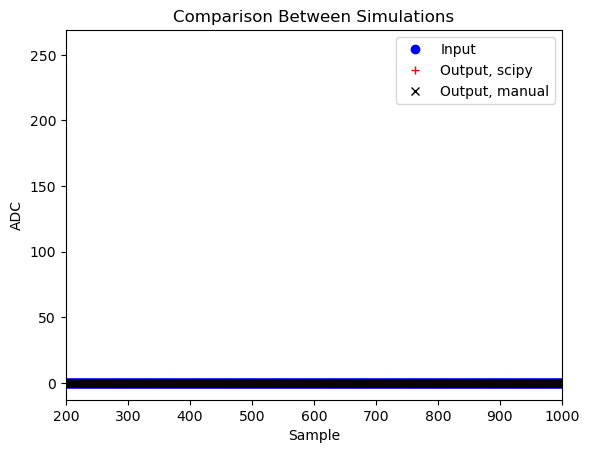

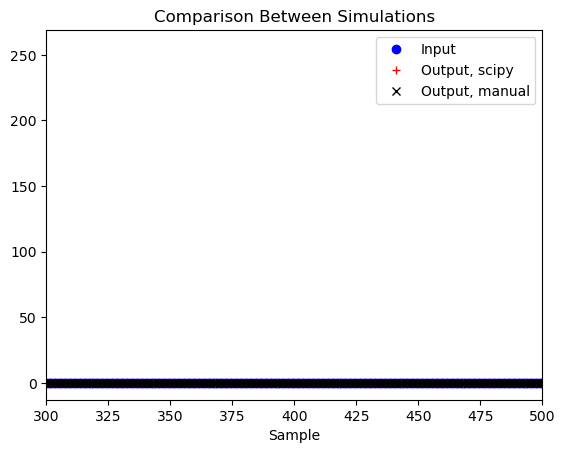

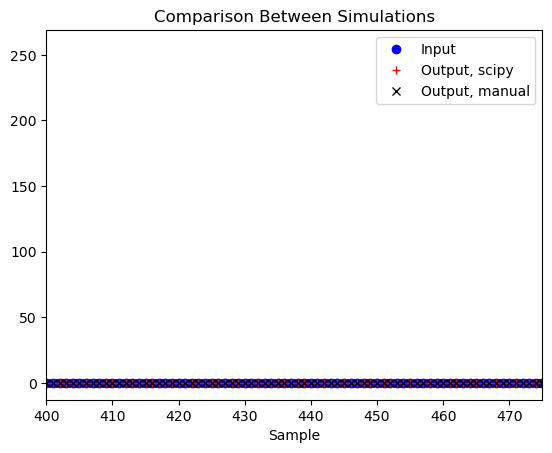

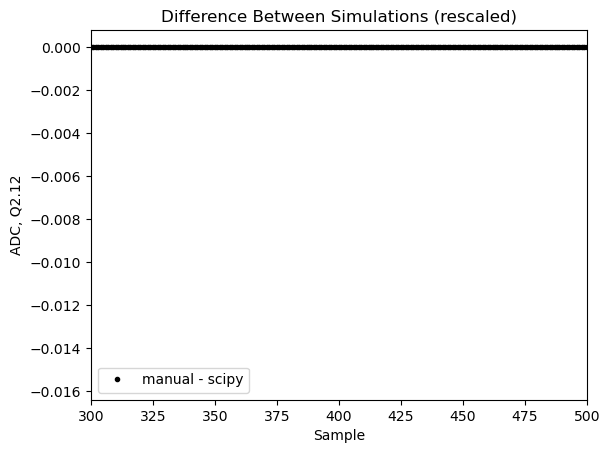

In [4]:
one_fixed = 16384 # This is 2**14, which is 1 in our Q4.14 coefficient notation

zero_coeffs = [1,0.5,0.3]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)

# Zero
output0_filtered = lfilter(zero_fir_coeff, [1], input0)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
#manual_fir_zero_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):
output0_manual_filtered = manual_fir_section_convert((np.array(zero_coeffs),),input0,
                                                     coeff_int   = 4,
                                                     coeff_frac  = 14,
                                                     data_int    = 17,
                                                     data_frac   = 13,
                                                     out_int     = 14,
                                                     out_frac    = 2)
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))


plt.title("Comparison Between Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.legend()
plt.xlim(200,1000)
plt.show()


plt.title("Comparison Between Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(300,500)
plt.savefig("output.png")
plt.show()

plt.title("Comparison Between Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(400,475)
plt.show()


plt.title("Difference Between Simulations (rescaled)")
plt.plot(np.array(range(len(output0_filtered))), (output0_manual_filtered - output0_filtered)/one_fixed, linestyle="None", 
         marker=".", label = "manual - scipy", color="k")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.ylabel("ADC, Q2.12")
plt.legend()
plt.xlim(300,500)
# plt.ylim(-0.15, 0.15)
# plt.savefig("output.png")
plt.show()

# IIR Testing

[ 16384 -22938  24084 -22479  19668 -16522  16384 -22938  24084 -22479
  19668 -16522  13492  -6612 -10795   5289   8500   -817  -1245    609
    925]
[ 16384 239206  24084 239665  19668 245622  16384 239206  24084 239665
  19668 245622  13492 255532 251349   5289   8500 261327 260899    609
    925]
Swapping Coefficients in the C block!!!!
C[0]: -817
C[1]: -1245
C[2]: 925
C[3]: 609
arr_intermediate[0][i-2]: 0
arr_intermediate[1][i-2]: 0
F[0]: 0
G[0]: 0
arr_intermediate[0][i]: 0
arr_intermediate[1][i]: 0
arr[0][i] after: 0
arr[1][i] after: 0


C[0]: -817
C[1]: -1245
C[2]: 925
C[3]: 609
arr_intermediate[0][i-2]: 0
arr_intermediate[1][i-2]: 0
F[1]: 0
G[1]: 0
arr_intermediate[0][i]: 0
arr_intermediate[1][i]: 0
arr[0][i] after: 0
arr[1][i] after: 0


C[0]: -817
C[1]: -1245
C[2]: 925
C[3]: 609
arr_intermediate[0][i-2]: 0
arr_intermediate[1][i-2]: 0
F[2]: 0
G[2]: 0
arr_intermediate[0][i]: 0
arr_intermediate[1][i]: 0
arr[0][i] after: 0
arr[1][i] after: 0


C[0]: -817
C[1]: -1245
C[2]: 925
C[3

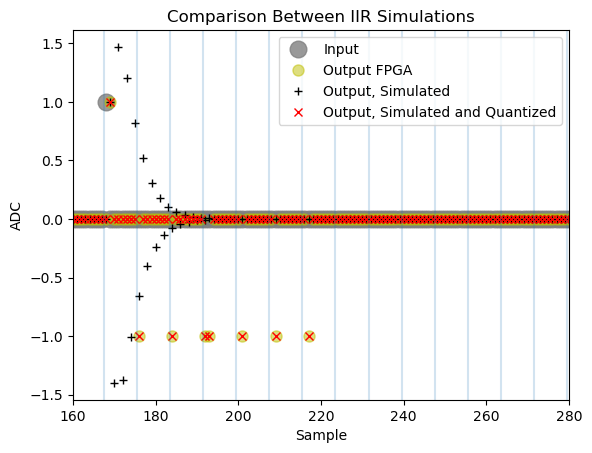

In [13]:
SWAP_COEFFS=True

data = import_data("CaptureData/capture_240917_smallImpulse_Mag_0p7_Angle_Pi_IIR_after.npy")
# data = import_data("CaptureData/capture_240917_A_0_B_1_doubleImpulse_IIRCoeffs_IIR_after.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]
# print(input0_offset)
input0 = input0[input0_offset-8*3:]
input1 = input1[input0_offset-8*3:]
output0 = output0[input0_offset-8*3:]
output1 = output1[input0_offset-8*3:]

known_delay = output0_offset - input0_offset - 1 # The 1 is from the delay is manually applied to align with the groupings of 8

# input0=np.array(input0)/4

mag=0.7
angle=np.pi
coeffs = iir_biquad_coeffs(mag, angle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.array(np.floor(coeffs[i] * (2**14)),dtype=np.int16)
    coeffs_fixed_point[i] = convert_to_fixed_point(np.array(coeffs[i]), 4, 14)
    coeffs_returned[i] = convert_from_fixed_point(np.array(coeffs_fixed_point[i]), 4, 14)
print(coeffs_fixed_point_signed)
print(coeffs_fixed_point)
b=[0,1,0]
# b, a = signal.iirnotch(350, 5, 3000)
# pole = signal.tf2zpk(b,a)[1][0]
# mag=np.abs(pole)
# angle=np.angle(pole)
# coeffs = iir_biquad_coeffs(mag, angle, samp_per_clock=8)
# coeffs_fixed_point = np.zeros(len(coeffs), dtype=int)
# coeffs_returned = np.zeros(len(coeffs), dtype=float)
# for i in range(len(coeffs_fixed_point)):
#     # Coefficients are in Q4.14, where the sign bit IS counted
#     coeffs_fixed_point[i] = convert_to_fixed_point(coeffs[i], 4, 14)
#     coeffs_returned[i] = convert_from_fixed_point(coeffs_fixed_point[i], 4, 14)
# print(coeffs_returned-coeffs)
# print("b: %s"%(b))
# print("a: %s"%(a))
# print("coeffs: %s"%coeffs)

# # coeffs_custom = [16384,  22685,  17268,   4328, 253231, 246067,  16384,  22685,  17268,   4328,
# #  253231, 246067, 247577,  12573, 255851,   5431,   3861,   7563, 255832, 0, 0]#
# coeffs_custom = np.floor_divide(np.array([16384,  22685,  17268,   4328, 253231, 246067,  16384,  22685,  17268,   4328,
#  253231, 246067, 247577,  12573, 255851,   5431,   3861,   7563, 255832, 0, 0], dtype=int),1)#
# print(coeffs_custom)
# coeffs_returned_custom = np.zeros(len(coeffs_custom), dtype=float)
# for i in range(len(coeffs_fixed_point)):
#     coeffs_returned_custom[i] = convert_from_fixed_point(coeffs_custom[i], 4, 14)
# b=[0,1,0]

input_delayed = np.concatenate((np.zeros(known_delay), np.array(input0), np.zeros(8-(known_delay%8))))
input_with_FIR = signal.lfilter(b, [1], input_delayed)

# Hugo's Sim
biquad = Biquad_Hugo(data=input_delayed, A=0, B=1, P=mag, theta=angle, M=8)
biquad.IIR()
output = biquad.get_biquad()
output_hugo = np.array(output).flatten()

# output0_manual_filtered_patrick_stage1 = iir_biquad_patrick( np.array(input_with_FIR), 8, mag, angle, ics = None )
# output0_manual_filtered_patrick = output0_manual_filtered_patrick_stage1#signal.lfilter(b, [1], output0_manual_filtered_patrick_stage1)

output0_manual_filtered_patrick_stage1 = iir_biquad_patrick( np.array(input_with_FIR), 8, mag, angle, ics = None )
output0_manual_filtered_patrick = output0_manual_filtered_patrick_stage1#signal.lfilter(b, [1], output0_manual_filtered_patrick_stage1)

if SWAP_COEFFS:
    print("Swapping Coefficients in the C block!!!!")
    temp = coeffs_fixed_point_signed[-1]
    coeffs_fixed_point_signed[-1] = coeffs_fixed_point_signed[-2]
    coeffs_fixed_point_signed[-2] = temp

output0_manual_filtered_quantized_stage1 = iir_biquad_run_fixed_point(np.array(input_with_FIR), coeffs_fixed_point_signed, 
                                                                      decimate=True, mag=mag, angle=angle,debug=1)
output0_manual_filtered_quantized = output0_manual_filtered_quantized_stage1#signal.lfilter(b, [1], output0_manual_filtered_quantized_stage1)

output0_filtered_stage1 = lfilter([1], a, input_with_FIR)
output0_filtered = output0_filtered_stage1#signal.lfilter(b, [1], output0_filtered_stage1)

output0_manual_filtered_stage1 = manual_iir_section((a,),np.array(input_with_FIR))#output0_manual_filtered_stage1)
output0_manual_filtered = output0_manual_filtered_stage1#signal.lfilter(b, [1], output0_manual_filtered_stage1)

plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(input_with_delayed))), input_delayed, linestyle="None", 
         marker="o", label = "Input", color="grey", markersize=12, alpha=0.8)
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker="o", label = "Output FPGA", color="y", markersize=8, alpha=0.5)
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker=".", label = "Manual IIR", color="b", markersize=8, alpha=0.5)
plt.plot(np.array(range(len(output0_manual_filtered_patrick))), output0_manual_filtered_patrick, linestyle="None", 
         marker="+", label = "Output, Simulated", color="k")
plt.plot(np.array(range(len(output0_manual_filtered_quantized))), output0_manual_filtered_quantized, linestyle="None", 
         marker="x", label = "Output, Simulated and Quantized", color="r")
# plt.plot(np.array(range(len(output_hugo))), output_hugo, linestyle="None", 
#          marker="2", label = "Output, Hugo", color="purple", markersize=10)
# plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
#          marker="2", label = "Output, lfiltered", color="purple")
for x_line in range(0,300,8):
    plt.axvline(x=x_line-0.5, alpha=0.2)
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.legend()
plt.xlim(160,280)
# plt.xlim(-1,20)
# plt.ylim(-50,50)
plt.savefig("output.png")
plt.show()

In [6]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
np.right_shift(-1,10000)

# Testing Hugo's Results

In [ ]:
mag=1#np.abs(pole)
angle=0.5#np.pi/2#np.angle(pole)
coeffs = iir_biquad_coeffs(mag, angle, samp_per_clock=8)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=int)
coeffs_returned = np.zeros(len(coeffs), dtype=float)
input0 = np.zeros(1024)
input0[8*3] = 1000
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point[i] = convert_to_fixed_point(coeffs[i], 4, 25)
    coeffs_returned[i] = convert_from_fixed_point(coeffs_fixed_point[i], 4, 25)
print("coeffs: %s"%coeffs)

output0_manual_filtered_patrick_stage1 = iir_biquad_patrick( np.array(input0), 8, mag, angle, ics = None )
output0_manual_filtered_patrick = output0_manual_filtered_patrick_stage1#signal.lfilter(b, [1], output0_manual_filtered_patrick_stage1)

output0_manual_filtered_quantized_stage1 = iir_biquad_run(np.array(input0), coeffs_returned, decimate=True)
output0_manual_filtered_quantized = output0_manual_filtered_quantized_stage1#signal.lfilter(b, [1], output0_manual_filtered_quantized_stage1)

# output0_filtered_stage1 = lfilter([1], a, input_with_FIR)
# output0_filtered = output0_filtered_stage1#signal.lfilter(b, [1], output0_filtered_stage1)

# output0_manual_filtered_stage1 = manual_iir_section((a,),np.array(input_with_FIR))#output0_manual_filtered_stage1)
# output0_manual_filtered = output0_manual_filtered_stage1#signal.lfilter(b, [1], output0_manual_filtered_stage1)

plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="grey", markersize=12, alpha=0.8)
plt.plot(np.array(range(len(output0_manual_filtered_patrick))), output0_manual_filtered_patrick, linestyle="None", 
         marker="+", label = "Output, Patrick", color="k")
plt.plot(np.array(range(len(output0_manual_filtered_quantized))), output0_manual_filtered_quantized, linestyle="None", 
         marker="x", label = "Output, Simulated and Quantized", color="r")
for x_line in range(0,300,8):
    plt.axvline(x=x_line-0.5, alpha=0.2)
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.legend()
plt.xlim(20,80)
# plt.xlim(-1,20)
# plt.ylim(0,10)
plt.savefig("output.png")
plt.show()

# Patrick Script

In [ ]:
orig = np.zeros(1024)
orig[512] = 1000
orig[515] = 4000

notch_fq = 350
q = 5

b, a = signal.iirnotch(notch_fq, q, 3000)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs(mag, angle, samp_per_clock=8)

coeffs_fixed_point = np.zeros(len(coeffs), dtype=int)
coeffs_returned = np.zeros(len(coeffs), dtype=float)
coeffs_fixed_point2 = np.zeros(len(coeffs), dtype=int)
coeffs_returned2 = np.zeros(len(coeffs), dtype=float)
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point[i] = convert_to_fixed_point(coeffs[i], 4, 14)
    coeffs_returned[i] = convert_from_fixed_point(coeffs_fixed_point[i], 4, 14)
    coeffs_fixed_point2[i] = convert_to_fixed_point(coeffs[i], 4, 13)#14)
    coeffs_returned2[i] = convert_from_fixed_point(coeffs_fixed_point2[i], 4, 13)#14)

oinit = iir_biquad_run(np.array(orig), coeffs)#iir_biquad_patrick(np.array(orig), 8, mag, angle)#= test_patrick()
b2, a2 = signal.iirnotch(notch_fq, q, 3000)
ofinal = signal.lfilter(b2, [1], oinit)

oinit2 = iir_biquad_run(np.array(orig), coeffs_returned2)#iir_biquad_patrick(np.array(orig), 8, mag, angle)#= test_patrick()
b2, a2 = signal.iirnotch(notch_fq, q, 3000)
ofinal2 = signal.lfilter(b2, [1], oinit2)

o = signal.lfilter(b2, a2, np.array(orig))


diff = o - ofinal
diff2 = o - ofinal2
plt.plot(diff2, label="Look-Ahead, Quantized")
plt.plot(diff, label="Look-Ahead, Not Quantized")
# plt.plot(diff, label="Quantized")
plt.legend()
plt.show()

plt.semilogy(diff2, label="Look-Ahead, Quantized")
plt.semilogy(diff, label="Look-Ahead, Not Quantized")
# plt.plot(diff, label="Quantized")
plt.legend()
plt.show()
plt.show()

# Depricated

# Checking Frequency Response

In [ ]:
def sample_generator(frequency, n_samples=8*8, m=8, flatten=False, phase=0):
    indicies = np.arange(n_samples)
    indicies = indicies.reshape(int(n_samples/m), m)
    values = np.cos((np.pi*frequency)*indicies + phase)
    if flatten:
        values = values.flatten()
        indicies = indicies.flatten()
    return indicies,values

def power_ratio(values, values_filtered):
    return (np.sum(np.power(np.abs(values_filtered),2)))/(np.sum(np.power(np.abs(values),2)))

def amp_ratio(values, values_filtered):
    return (np.sum(np.abs(values_filtered)))/(np.sum(np.abs(values)))

def amp_ratio_dft(values, values_filtered):
    return (np.sum(np.abs(values_filtered)))/(np.sum(np.abs(values)))

def power_ratio_dft(values, values_filtered):
    # return (np.sum(np.power(np.abs(values_filtered),2)))/(np.sum(np.power(np.abs(values),2)))

def eval_biquad_filter_lfilter(b,a,sample_freqs, internal_samples=8*100, amplitude=False, phase=0):
    sample_freqs = np.linspace(0,0.99,samples)
    n_samples = internal_samples
    power_ratios = []
    window = np.hanning(n_samples)
    for freq_i in sample_freqs:
        indicies, values = sample_generator(freq_i, n_samples=n_samples, m=1, flatten=True, phase=phase)
        values = np.multiply(window, values)
        fft_result = np.fft.fft(values)
        values_filtered = lfilter(b,a,values)        
        fft_filter_result = np.fft.fft(values_filtered)
        if amplitude:
            power_ratios.append(amp_ratio_dft(fft_result, fft_filter_result)) 
        else:
            power_ratios.append(power_ratio_dft(fft_result, fft_filter_result))  
            
    power_ratios = power_ratios/np.max(power_ratios)

    return power_ratios


def eval_biquad_filter_simulation(mag, angle, sample_freqs, internal_samples=8*100, amplitude=False, phase=0):
    sample_freqs = np.linspace(0,0.99,samples)
    n_samples = internal_samples
    power_ratios = []
    window = np.hanning(n_samples)
    for freq_i in sample_freqs:
        indicies, values = sample_generator(freq_i, n_samples=n_samples, m=1, flatten=True, phase=phase)
        values = np.multiply(window, values)
        fft_result = np.fft.fft(values)
        values_filtered = iir_biquad_patrick(np.array(values), 8, mag, angle, ics = None )        
        fft_filter_result = np.fft.fft(values_filtered)
        if amplitude:
            power_ratios.append(amp_ratio_dft(fft_result, fft_filter_result)) 
        else:
            power_ratios.append(power_ratio_dft(fft_result, fft_filter_result))  
            
    power_ratios = power_ratios/np.max(power_ratios)

    return power_ratios

In [ ]:
fs = 3000
b, a = signal.iirnotch(350, 5, fs)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
samples = 10000
sample_freqs =  np.linspace(0,0.99,samples)
results = eval_biquad_filter_lfilter(b,a,sample_freqs, internal_samples=8*100, amplitude=False, phase=0)
results2 = eval_biquad_filter_simulation(mag,angle,sample_freqs, internal_samples=8*100, amplitude=False, phase=0)
freqz, hz = signal.freqz(b, a, fs=fs)

In [ ]:
plt.semilogy(fs*sample_freqs/2, results2)
plt.semilogy(freqz, hz)
plt.show()

## Old multiple plots

In [ ]:
### b, a = signal.iirnotch(350, 5, 3000)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs(mag, angle, samp_per_clock=8)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=int)
coeffs_returned = np.zeros(len(coeffs), dtype=float)
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point[i] = convert_to_fixed_point(coeffs[i], 4, 14)
    coeffs_returned[i] = convert_from_fixed_point(coeffs_fixed_point[i], 4, 14)
# print(coeffs_returned-coeffs)
print("b: %s"%(b))
print("a: %s"%(a))
print("coeffs: %s"%coeffs)

one_fixed = 16384
zero_coeffs = [1,0,0]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)
pole_fir_coeff = np.array(pole_coeffs, dtype=float)
iir_coeff = np.array(iir_coeffs, dtype=float)

output0_filtered_step1 = lfilter(b, a, input0)
# output0_filtered = lfilter(pole_fir_coeff, iir_coeff, output0_filtered_step1)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered_step1)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
print(b)
print(a)
output0_manual_filtered_stage1 = manual_fir_section_convert((b,),input0,
                                                             coeff_int   = 4,
                                                             coeff_frac  = 14,
                                                             data_int    = 17,
                                                             data_frac   = 13,
                                                             out_int     = 14,
                                                             out_frac    = 2)#*one_fixed*one_fixed/16
output0_manual_filtered = manual_iir_section((a,),output0_manual_filtered_stage1)
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))

output0_manual_filtered2 = iir_biquad_run(input0, coeffs)
output0_manual_filtered2 = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered2)))

output0_manual_filtered_patrick = iir_biquad_patrick( np.array(input0), 8, mag, angle, ics = None )
output0_manual_filtered_patrick = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered_patrick)))


plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker="1", label = "Output", color="y")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="*", label = "Output, scipy", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="+", label = "Output, manual", color="k")
plt.plot(np.array(range(len(output0_manual_filtered2))), output0_manual_filtered2, linestyle="None", 
         marker="x", label = "Output, clustered look ahead", color="g")
for x_line in range(0,300,8):
    plt.axvline(x=x_line-0.5)
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.legend()
plt.xlim(20,270)
plt.show()


plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker="1", label = "Output", color="y")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="*", label = "Output, scipy", color="r")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="+", label = "Output, manual", color="k")
plt.plot(np.array(range(len(output0_manual_filtered2))), output0_manual_filtered2, linestyle="None", 
         marker="x", label = "Output, clustered look-ahead", color="g")
plt.plot(np.array(range(len(output0_manual_filtered_patrick))), output0_manual_filtered_patrick, linestyle="None", 
         marker="+", label = "Output, clustered Patrick", color="k")
for x_line in range(0,300,8):
    plt.axvline(x=x_line-0.5)
plt.xlabel("Sample")
plt.legend()
plt.xlim(160,200)
plt.savefig("output.png")
plt.show()

plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(output0))), input0, linestyle="None", 
         marker=".", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker=".", label = "Output", color="k")
# plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
#          marker="*", label = "Output, scipy", color="r")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="+", label = "Output, manual", color="k")
plt.plot(np.array(range(len(output0_manual_filtered2))), output0_manual_filtered2, linestyle="None", 
         marker="x", label = "Output, clustered look ahead", color="r")
for x_line in range(0,300,8):
    plt.axvline(x=x_line-0.5)
plt.xlabel("Sample")
plt.legend()
plt.xlim(10,40)
plt.show()

plt.title("Comparison Between IIR Simulations")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker=".", label = "Output", color="k")
# plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
#          marker="*", label = "Output, scipy", color="r")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="+", label = "Output, manual", color="k")
plt.plot(np.array(range(len(output0_manual_filtered2))), output0_manual_filtered2, linestyle="None", 
         marker="x", label = "Output, clustered look ahead", color="r")

for x_line in range(0,300,8):
    plt.axvline(x=x_line-0.5)
plt.xlabel("Sample")
plt.legend()
plt.xlim(160,200)
plt.show()


plt.title("Difference Between IIR Simulations (rescaled)")
plt.plot(np.array(range(len(output0_filtered))), (output0_manual_filtered - output0_filtered)/one_fixed, linestyle="None", 
         marker=".", label = "manual - scipy", color="k")
plt.plot(np.array(range(len(output0_filtered))), (output0_manual_filtered2 - output0_filtered)/one_fixed, linestyle="None", 
         marker=".", label = "clustered - scipy", color="r")
# plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
#          marker="x", label = "Output, manual", color="k")
plt.xlabel("Sample")
plt.ylabel("ADC, Q2.12")
plt.legend()
plt.xlim(0,200)
# plt.ylim(-0.15, 0.15)
plt.savefig("output.png")
plt.show()


In [ ]:
# Adapted from https://github.com/barawn/pueo-dsp-python/tree/main/dsp. It is not tracked because I don't want to set up a submodule right now
def iir_biquad_update(ins, mag, angle, samp_per_clock=8, ics = None, manual_filter=False):
    if ics is None:
        # Debugging
        print("No initial conditions!")
        ics = np.zeros(samp_per_clock*3)
        ics = ics.reshape(3,-1)

    # Calculate the f and g fir coefficients, using the angle of the notch, the samples
    f_fir = get_f_coeffs(samp_per_clock, mag, angle)
    g_fir = get_g_coeffs(samp_per_clock, mag, angle)

    # Debugging.
    print("Magnitude:", mag, "Angle:", angle)
    print("f/g FIRs are calculated only for sample 0 and sample 1 respectively.")
    print("f FIR:", f_fir)
    print("g FIR:", g_fir)

    # Expand the inputs with the initial conditions
    newins = np.concatenate( (ics[0],ins) )

    # Run the FIRs
    if(manual_filter):
        raise Exception("Not implemented yet")
    else:
        f = signal.lfilter( f_fir, [1], newins )
        g = signal.lfilter( g_fir, [1], newins )
        # Now we decimate f/g by 8, because we only want the 0th and 1st samples out of 8 for each.
    
    f = f.reshape(-1, samp_per_clock).transpose()[0]
    g = g.reshape(-1, samp_per_clock).transpose()[1]
    
    # n.b. f[0]/g[0] are initial conditions

    # Lucas note: I think this should be f[1] and g[1]
    # f[2] (real sample 8) is calculated from 8, 7, 6, 5, 4, 3, 2.
    # g[2] (real sample 9) is calculated from 9, 8, 7, 6, 5, 4, 3, 2.

    # Now we need to compute the F and G functions, which *again* are just FIRs,
    # however they're cross-linked, so it's a little trickier.
    # We split it into
    # F = (fir on f) + G_coeff*g(previous clock)
    # G = (fir on g) + F_coeff*f(previous clock)

    ## D_FF = -1*pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock-2, np.cos(angle)) #L -alpha
    ## E_GG =  pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock, np.cos(angle)) #L delta

    ## # Crosslink coefficients. 
    ## D_FG = pow(mag, samp_per_clock-1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L beta
    ## # Lucas note - This was changed to add a negative sign, better matching the paper
    ## E_GF = -1*pow(mag, samp_per_clock+1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L -gamma

    D_FF, D_FG, E_GF, E_GG = get_F_G_coefficients(samp_per_clock, mag, angle)
    
    F_fir = [ 1.0, D_FF ] # This is for sample 0
    G_fir = [ 1.0, E_GG ] # This is for sample 1

    # Debugging
    print("F/G FIRs operate on f/g inputs respectively")
    print("D_FF:", D_FF, " D_FG:", D_FG)
    print("E_GG:", E_GG, " E_GF:", E_GF)
    print()
    
    # print("F/G FIRs operate on f/g inputs respectively")
    # print("F FIR:", F_fir, "+g*", D_FG)
    # print("G FIR:", G_fir, "-f*", E_GF)
    # print()
    # print("As full FIRs calculated only for sample 0 and 1 respectively:")
    # print("F = f + (fz^-", samp_per_clock, ")+",Coeff_g_in_F,"*(gz^-", samp_per_clock-1, ")",sep='')
    # print("G = g + (gz^-", samp_per_clock, ")+",Coeff_f_in_G,"*(fz^-", samp_per_clock+1, ")",sep='')
        
    # Filter them
    F = signal.lfilter( F_fir, [1], f )
    G = signal.lfilter( G_fir, [1], g )

    # Now we need to feed the f/g paths into the opposite filter
    # F[0]/G[0] are going to be dropped anyway.
    F[1:] += D_FG*g[0:-1]
    G[1:] += E_GF*f[0:-1]    

    # drop the initial conditions
    F = F[1:]
    G = G[1:]
    
    # Now reshape our outputs.
    arr = ins.reshape(-1, samp_per_clock).transpose()
    # arr[0] is now every 0th sample (e.g. for samp_per_clock = 8, it's 0, 8, 16, 24, etc.)
    # arr[1] is now every 1st sample (e.g. for samp_per_clock = 8, it's 1, 9, 17, 25, etc.)

    # IIR parameters. See the 'update step' in paper.
    C = np.zeros(4)
    C[0] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock-2, np.cos(angle)), 2) -
                                       pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

    C[1] = pow(mag, 2*samp_per_clock-1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
                                         (eval_chebyu(samp_per_clock,np.cos(angle)) -
                                          eval_chebyu(samp_per_clock-2, np.cos(angle))))

    C[2] = pow(mag, 2*samp_per_clock+1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
                                         (eval_chebyu(samp_per_clock-2, np.cos(angle))-
                                          eval_chebyu(samp_per_clock, np.cos(angle))))

    C[3] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock, np.cos(angle)), 2) -
                                       pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

    # Debugging
    print("Update step (matrix) coefficients:", C)
    print("As an IIR: (Lucas thinks there is a typo here)")
    print("y[0] =", C[1], "*z^-", samp_per_clock*2-1," + ", C[0], "*z^-", samp_per_clock*2,
          "+F[0]",sep='')
    print("y[1] =", C[3], "*z^-", samp_per_clock*2," + ", C[2], "*z^-", samp_per_clock*2+1,
          "+G[1]",sep='')
    # Now compute the IIR.
    # INITIAL CONDITIONS STEP
    y0_0 =  C[0]*ics[1][0] + C[1]*ics[1][1] + F[0]
    y1_0 =  C[2]*ics[1][0] + C[3]*ics[1][1] + G[0]
    y0_1 =  C[0]*ics[2][0] + C[1]*ics[2][1] + F[1]
    y1_1 =  C[2]*ics[2][0] + C[3]*ics[2][1] + G[1]
    for i in range(len(arr[0])):
        if i == 0:
            # Compute from initial conditions.
            arr[0][i] = C[0]*y0_0 + C[1]*y1_0 + F[i]
            arr[1][i] = C[2]*y0_0 + C[3]*y1_0 + G[i]
        elif i==1:
            # Compute from initial conditions
            arr[0][i] = C[0]*y0_1 + C[1]*y1_1 + F[i]
            arr[1][i] = C[2]*y0_1 + C[3]*y1_1 + G[i]
        else:
            # THIS IS THE ONLY RECURSIVE STEP
            arr[0][i] = C[0]*arr[0][i-2] + C[1]*arr[1][i-2] + F[i]
            arr[1][i] = C[2]*arr[0][i-2] + C[3]*arr[1][i-2] + G[i]

        # THIS IS NOT RECURSIVE B/C WE DO NOT TOUCH THE SECOND INDEX
        for j in range(2, samp_per_clock):
            arr[j][i] += 2*mag*np.cos(angle)*arr[j-1][i] - pow(mag, 2)*arr[j-2][i]

    # now transpose arr and flatten
    return arr.transpose().reshape(-1)

# Actual Data

In [ ]:
data = import_data("CaptureData/capture_082124_A_0_B_1_impulse_Xall_16384_fg.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]

In [ ]:
plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker=".", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker=".", label = "Output", color="r")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()

# plt.plot(np.array(range(len(captured_data[1]))), captured_data[1], linestyle="None", 
#          marker=".", label = "In ADC 1")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

# plt.title("Post Filter Out")
# plt.plot(np.array(range(len(captured_data[2]))), captured_data[2], linestyle="None", 
#          marker=".", label = "Out DAC 6")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)

# plt.plot(np.array(range(len(captured_data[3]))), captured_data[3], linestyle="None", 
#          marker=".", label = "Out DAC 7")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

In [ ]:
np.zeros(8*3).reshape(3,-1)

In [ ]:
one_fixed = 16384 # This is 2**14, which is 1 in our Q4.14 coefficient notation

zero_coeffs = [1,2,3]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)

# Zero
output0_filtered = lfilter(zero_fir_coeff, [1], input0)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
output0_manual_filtered = manual_fir_zero_section((np.array(zero_coeffs,dtype=int)*one_fixed,),input0)/4#*one_fixed/4
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))


plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()


plt.title("Zoomed")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(300,500)
plt.show()

plt.title("Zoomed 2")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(400,475)
plt.show()


# Actual Data

In [ ]:
data = import_data("CaptureData/capture_082124_A_0_B_1_impulse_Xall_16384_fg.npy")
input0 = data[0]
input1 = data[1]
output0 = data[2]
output1 = data[3]
input0_offset = data[4]
input1_offset = data[5]
output0_offset = data[6]
output1_offset = data[7]

In [ ]:
known_delay = output0_offset - input0_offset - 1 # The 1 is from the delay is manually applied to align with the groupings of 8

In [ ]:
plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker=".", label = "Input", color="b")
plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
         marker=".", label = "Output", color="r")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()

# plt.plot(np.array(range(len(captured_data[1]))), captured_data[1], linestyle="None", 
#          marker=".", label = "In ADC 1")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

# plt.title("Post Filter Out")
# plt.plot(np.array(range(len(captured_data[2]))), captured_data[2], linestyle="None", 
#          marker=".", label = "Out DAC 6")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)

# plt.plot(np.array(range(len(captured_data[3]))), captured_data[3], linestyle="None", 
#          marker=".", label = "Out DAC 7")
# # print("[%f, %f]"%(np.max(captured_data[index])/(2.0**15),np.min(captured_data[index])/(2.0**15)))
# plt.xlabel("Samples")
# plt.legend()
# plt.xlim(200,1000)
# plt.show()

In [ ]:
np.zeros(8*3).reshape(3,-1)

In [ ]:
one_fixed = 16384 # This is 2**14, which is 1 in our Q4.14 coefficient notation

zero_coeffs = [1,2,3]
pole_coeffs = [1,0,0,0,0,0]
iir_coeffs = [1,0.9,0]

zero_fir_coeff = np.array(zero_coeffs, dtype=float)

# Zero
output0_filtered = lfilter(zero_fir_coeff, [1], input0)
output0_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_filtered)))

# The divide by 4 corrects for the two fractional (useless) bits
# The re-multiplication by one_fixed is for comparison with the scipy.signal outputs
output0_manual_filtered = manual_fir_zero_section((np.array(zero_coeffs,dtype=int)*one_fixed,),input0)/4#*one_fixed/4
output0_manual_filtered = np.concatenate((np.zeros(known_delay), np.array(output0_manual_filtered)))


plt.title("")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(200,1000)
plt.show()


plt.title("Zoomed")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(300,500)
plt.show()

plt.title("Zoomed 2")
plt.plot(np.array(range(len(input0))), input0, linestyle="None", 
         marker="o", label = "Input", color="b")
# plt.plot(np.array(range(len(output0))), output0, linestyle="None", 
#          marker="x", label = "Output", color="g")
plt.plot(np.array(range(len(output0_filtered))), output0_filtered, linestyle="None", 
         marker="+", label = "Output Filtered", color="r")
plt.plot(np.array(range(len(output0_manual_filtered))), output0_manual_filtered, linestyle="None", 
         marker="x", label = "Output Manual Filtered", color="k")
plt.xlabel("Sample")
plt.legend()
plt.xlim(400,475)
plt.show()


In [ ]:
orig = np.zeros(1024)
orig[512] = 1000
b, a = signal.iirnotch(350, 5, 3000)
pole = signal.tf2zpk(b,a)[1][0]
mag=np.abs(pole)
angle=np.angle(pole)
coeffs = iir_biquad_coeffs( mag, angle, samp_per_clock=8)
print(coeffs)
result = iir_biquad_run(orig, coeffs, samp_per_clock=8)
print(result)

In [ ]:
test()

In [ ]:
# def import_data(file_loc, truncate=True, debug = False):
#     captured_data = np.load(file_loc)
#     input0_offset=np.argmax((np.abs(captured_data[0])>0).astype(int))
#     input1_offset=np.argmax((np.abs(captured_data[1])>0).astype(int))
#     output0_offset=np.argmax((np.abs(captured_data[2])>0).astype(int))
#     output1_offset=np.argmax((np.abs(captured_data[3])>0).astype(int))
    
#     # Truncate to 12 bits from 16, but store in 16 MSB aligned
#     input0 = captured_data[0]
#     input1 = captured_data[1]
#     if(truncate):
#         input0 = np.right_shift(input0,4)
#         input0 = np.left_shift(input0,4).astype(np.int16)
        
#         input1 = np.right_shift(input1,4)
#         input1 = np.left_shift(input1,4).astype(np.int16)

#     output0 = captured_data[2]
#     output1 = captured_data[3]

#     if(debug):
#         print("input0_offset: %s"%(input0_offset))
#         print("input1_offset: %s"%(input1_offset))
#         print("output0_offset: %s"%(output0_offset))
#         print("output1_offset: %s"%(output1_offset))

#         print("input0_offset%%8: %s"%(input0_offset%8))
#         print("input1_offset%%8: %s"%(input1_offset%8))
#         print("output0_offset%%8: %s"%(output0_offset%8))
#         print("output1_offset%%8: %s"%(output1_offset%8))

#         print("input 0 first value: %s"%input0[input0_offset])
#         print("input 1 first value: %s"%input1[input1_offset])
    
#     return (input0, input1, output0, output1, input0_offset, input1_offset, output0_offset, output1_offset)

## Conversions and Utility

In [ ]:
# def bindigits(n, bits):
#     """ https://stackoverflow.com/questions/12946116/twos-complement-binary-in-python
#     Takes an integer value and number of bits, and converts to two's complement string
#     Basically just masks off the number of bits. Python twos-complement are infinite length (...111111111101, for example)
#     """
#     s = bin(n & int("1"*bits, 2))[2:] # The [2:] cuts off the 0b of 0b######
#     return ("{0:0>%s}" % (bits)).format(s)

# def twos_complement_integer(n, bits):
#     """ Returns two's complement representation of n as a <bits> bit number
#     """
#     return int(bindigits(n,bits),2)

# def convert_to_fixed_point(a, a_int, a_frac, allow_overflow=False):
#     """Converts to an integer with <a_frac> bits of of fractional representation, and <a_int> bits of integer
#     i.e. Q<a_int>.<a_frac> (ARM)
#     """
#     if((a>=(2**(a_int-1)) or a<-1*(2**(a_int-1))) and not allow_overflow):
#         raise Exception("Value %s out of bounds"%a)
#     # Multiply fractional bits up to integers
#     # Removing digits of a twos complement goes more negative, so we mimic that in advance
#     a_temp = math.floor(a * (2**a_frac))

#     if (a<0):
#         # Convert to twos complement
#         # print("Converting to twos complement")
#         # print("%s = %s"%(a_temp, bin(a_temp)))
#         a_temp = twos_complement_integer(a_temp, a_int+a_frac)
#         # print("%s = %s"%(a_temp, bin(a_temp)))
#         # print(bin(a_temp))
#     a_temp = a_temp & int("1"*(a_int+a_frac), 2)
#     return a_temp

# def convert_from_fixed_point(a, a_int, a_frac, twos_complement=True):
#     """Converts from a signed integer (Q<a_int>.<a_frac>, ARM) representation to a floating point
#     """
#     if(a<0):
#         raise Exception("Expecting a to be respresented as an unsigned number")
#     bits = a_int + a_frac
    
#     if(twos_complement):
#         if(a>=2**(bits+1)):
#                 raise Exception("Value %s out of bounds. Bits available: %s"%(a,bits+1))
#         # If it is signed
#         if (a & (1<<(bits-1))):
#             # print("Signed")
#             a = (-1*(1<<(bits)) + a)
#     else:
#         if(a>=(2**(bits)) or a<-1*(2**(bits))):
#             raise Exception("Value %s out of bounds"%a)
#     a_temp = (a / (2.0**a_frac))#%(2**a_int)
    
#     return a_temp

In [ ]:
initial = 0.12345
val = convert_to_fixed_point(initial, 4, 14)

val2 = convert_from_fixed_point(val, 4, 14)
print("%s => %s"%(initial,val2))

In [ ]:
xs = np.linspace(-1,1,5000)
ys = [convert_from_fixed_point(convert_to_fixed_point(x,4,14),4,14) - x for x in xs]
plt.scatter(xs,ys, marker=".")
plt.title("Error in Conversion to Q4.14 Fixed Point")
plt.xlabel("Number Converted")
plt.ylabel("Difference")
plt.savefig("output.png")
plt.show()

In [ ]:
# def multiply(a, b, a_int, a_frac, b_int, b_frac, out_int, out_frac):
#     """ We are assuming that the fixed point limits of the inputs are already followed.
#     This means that normal multiplication is allowed if no error is thrown."""
#     a = convert_to_fixed_point(a, a_int, a_frac)
#     b = convert_to_fixed_point(b, b_int, b_frac)
#     result_int = a * b
#     return convert_from_fixed_point(result_int, out_int, out_frac, twos_complement=False)


In [ ]:
a=5.5
a_int=4
a_frac=1
b=7
b_int=4
b_frac=0
multiply(a, b, a_int, a_frac, b_int, b_frac,16,1)

## Manual but not FPGA-style

In [ ]:
# def manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):

    
#     for coeff_set in coeffs:
#         for c in coeff_set:
#             if(c >= 2**18 or c < -1*(2**18)):
#                 raise Exception("Coefficient out of bounds")
    
#     x = np.array(x)
#     y = np.zeros(len(x))
#     for coeff_set in coeffs:
#         for i in range(len(coeff_set), len(x)):
#             total = 0
#             for j in range(len(coeff_set)):
#                 c = convert_to_fixed_point(coeff_set[j], coeff_int, coeff_frac)
#                 x_point = convert_to_fixed_point(x[i-j], data_int, data_frac)
#                 total += c * x_point
#             # get actual value after fixed point math
#             y[i] = convert_from_fixed_point(total, coeff_int + data_int, coeff_frac+data_frac)
#             # Reduce to precision of output. In the firmware overflow is clipped off
#             val = convert_to_fixed_point(y[i], out_int, out_frac, allow_overflow=True)
#             y[i] = convert_from_fixed_point(val, out_int, out_frac)
# #             if(total>0):
# #                 print(total)
# #                 print(y[i])
#         x=np.copy(y)
#         y=np.zeros(len(x))
#     return x

# def manual_fir_pole_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):


#     # Sneaky reuse, clean up later
#     return manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int, out_frac)

#     # For pole FIR
#     #we get inputs in Q14.2 format. (NBITS-NFRAC, NFRAC)
#     #Internally we compute in Q21.27 format, coefficients in Q4.14 format
#     #So we shift to Q17.13 format.   
# #     x = np.array(x)
# #     y = np.zeros(len(x))
# #     for coeff_set in coeffs:
# #         for i in range(len(coeff_set), len(x)):
# #             total = 0
# #             for j in range(len(coeff_set)):
# # #                 print(coeff_set[j])
# #                 total += coeff_set[j] * x[i-j]
# #             y[i] = total
# #         x=np.copy(y)
# #         y=np.zeros(len(x))
# #     return x

# def manual_fir_zero_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int=22, out_frac=26):
#     # Each set of coefficients in the list is an FIR in series
#     # This may need removed in the future
    
#     # For zero FIR
#     #coeffs in Q4.14
#     #data in  Q18.12 and Q15.12
#     #trim to  Q14.12 for the preadder
#     #intermediate in Q22.26   
    
#     # Sneaky reuse, clean up later
#     return manual_fir_section_convert(coeffs, x, coeff_int, coeff_frac, data_int, data_frac, out_int, out_frac)

# def manual_fir_section(coeffs, x):
#     # Each set of coefficients in the list is an FIR in series
#     # This may need removed in the future
    
#     # For zero FIR
#     #coeffs in Q4.14
#     #data in  Q18.12 and Q15.12
#     #trim to  Q14.12 for the preadder
#     #intermediate in Q22.26   
    
#     for coeff_set in coeffs:
#         for c in coeff_set:
#             if(c >= 2**18 or c < -1*(2**18)):
#                 raise Exception("Coefficient out of bounds")
    
#     x = np.array(x)
#     y = np.zeros(len(x))
#     for coeff_set in coeffs:
#         for i in range(len(coeff_set), len(x)):
#             total = 0
#             for j in range(len(coeff_set)):
#                 total += coeff_set[j] * x[i-j]
#             y[i] = total#/(2**26)
# #             if(total>0):
# #                 print(total)
# #                 print(y[i])
#         x=np.copy(y)
#         y=np.zeros(len(x))
#     return x

# def manual_fir_pole_section(coeffs, x):
    
#     # Sneaky reuse, clean up later
#     return manual_fir_section(coeffs, x)

# def manual_fir_zero_section(coeffs, x):
    
#     # Sneaky reuse, clean up later
#     return manual_fir_section(coeffs, x)


# def manual_iir_section(coeffs, y):
#     y = np.array(y)
#     for coeff_set in coeffs:
#         for i in range(len(coeff_set), len(y)):
#             total = coeff_set[0] * y[i]
#             for j in range(1,len(coeff_set)):
# #                 print(coeff_set[j])
#                 total -= coeff_set[j] * y[i-j]
#             y[i] = total
#     return y

## Clustered Look-ahead

In [ ]:
# def get_f_coeffs(samp_per_clock, mag, angle):
#     f_fir = [0]*(samp_per_clock-2)
#     for i in range(0, samp_per_clock-2):
#         f_fir[i] = pow(mag, i)*eval_chebyu(i,np.cos(angle) )
#     return f_fir

In [ ]:
# def get_g_coeffs(samp_per_clock, mag, angle):
#     g_fir = [0]*(samp_per_clock-1)
#     for i in range(0, samp_per_clock-1):
#         g_fir[i] = pow(mag, i)*eval_chebyu(i,np.cos(angle) )
#     return g_fir

In [ ]:
# def get_F_G_coefficients(samp_per_clock, mag, angle):
#     D_FF = -1*pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock-2, np.cos(angle)) #L -alpha
#     E_GG =  pow(mag, samp_per_clock)*eval_chebyu(samp_per_clock, np.cos(angle)) #L delta

#     # Crosslink coefficients. 
#     D_FG = pow(mag, samp_per_clock-1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L beta
#     # Lucas note - This was changed to add a negative sign, better matching the paper
#     E_GF = -1*pow(mag, samp_per_clock+1)*eval_chebyu(samp_per_clock-1, np.cos(angle))#L -gamma
#     return np.array([D_FF, D_FG, E_GF, E_GG])

In [ ]:
# # Adapted from https://github.com/barawn/pueo-dsp-python/tree/main/dsp. It is not tracked because I don't want to set up a submodule right now
# def iir_biquad_coeffs(mag, angle, samp_per_clock=8):
#     # Calculate the f and g fir coefficients, using the angle of the notch, the samples
#     f_fir = get_f_coeffs(samp_per_clock, mag, angle)
#     g_fir = get_g_coeffs(samp_per_clock, mag, angle)

#     # Now we need to compute the F and G functions, which *again* are just FIRs,
#     # however they're cross-linked, so it's a little trickier.
#     # We split it into
#     # F = (fir on f) + G_coeff*g(previous clock)
#     # G = (fir on g) + F_coeff*f(previous clock)

#     D_FF, D_FG, E_GF, E_GG = get_F_G_coefficients(samp_per_clock, mag, angle)

#     # IIR parameters. See the 'update step' in paper.
#     C = np.zeros(4)
#     C[0] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock-2, np.cos(angle)), 2) -
#                                        pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

#     C[1] = pow(mag, 2*samp_per_clock-1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
#                                          (eval_chebyu(samp_per_clock,np.cos(angle)) -
#                                           eval_chebyu(samp_per_clock-2, np.cos(angle))))

#     C[2] = pow(mag, 2*samp_per_clock+1)*((eval_chebyu(samp_per_clock-1, np.cos(angle)))*
#                                          (eval_chebyu(samp_per_clock-2, np.cos(angle))-
#                                           eval_chebyu(samp_per_clock, np.cos(angle))))

#     C[3] = pow(mag, 2*samp_per_clock)*(pow(eval_chebyu(samp_per_clock, np.cos(angle)), 2) -
#                                        pow(eval_chebyu(samp_per_clock-1, np.cos(angle)), 2))

#     coeffs = np.zeros(2*samp_per_clock-3 + 4 + 4)
#     coeffs[0:samp_per_clock-2] = np.array(f_fir)
#     coeffs[samp_per_clock-2:2*samp_per_clock-3] = np.array(g_fir)
#     coeffs[2*samp_per_clock-3:2*samp_per_clock-3 + 4] = get_F_G_coefficients(samp_per_clock, mag, angle)
#     coeffs[2*samp_per_clock-3 + 4:2*samp_per_clock-3 + 4 + 4] = C
    
#     return coeffs

In [ ]:
# def iir_biquad_run(ins, coeffs, samp_per_clock=8, ics=None, manual_filter=False, decimate=False):
#     if ics is None:
#         # Debugging
#         print("No initial conditions!")
#         ics = np.zeros(samp_per_clock*3)
#         ics = ics.reshape(3,-1)
#     ins = np.array(ins)
#     # Expand the inputs with the initial conditions
#     newins = np.concatenate( (ics[0],ins) )

#     f_fir = coeffs[0:samp_per_clock-2]
#     g_fir = coeffs[samp_per_clock-2:2*samp_per_clock-3]
#     D_FF = coeffs[2*samp_per_clock-3 + 0]
#     D_FG = coeffs[2*samp_per_clock-3 + 1]
#     E_GF = coeffs[2*samp_per_clock-3 + 2]
#     E_GG = coeffs[2*samp_per_clock-3 + 3]
#     C = coeffs[2*samp_per_clock-3 + 4:2*samp_per_clock-3 + 4 + 4]

#     # Run the FIRs
#     if(manual_filter):
#         raise Exception("Not implemented yet")
#     else:
#         f = signal.lfilter( f_fir, [1], newins )
#         g = signal.lfilter( g_fir, [1], newins )
#         # Now we decimate f/g by 8, because we only want the 0th and 1st samples out of 8 for each.
    
#     f = f.reshape(-1, samp_per_clock).transpose()[0]
#     g = g.reshape(-1, samp_per_clock).transpose()[1]
    
#     # n.b. f[0]/g[0] are initial conditions

#     # Lucas note: I think this should be f[1] and g[1]
#     # f[2] (real sample 8) is calculated from 8, 7, 6, 5, 4, 3, 2.
#     # g[2] (real sample 9) is calculated from 9, 8, 7, 6, 5, 4, 3, 2.

#     # Now we need to compute the F and G functions, which *again* are just FIRs,
#     # however they're cross-linked, so it's a little trickier.
#     # We split it into
#     # F = (fir on f) + G_coeff*g(previous clock)
#     # G = (fir on g) + F_coeff*f(previous clock)
    
#     F_fir = [ 1.0, D_FF ] # This is for sample 0
#     G_fir = [ 1.0, E_GG ] # This is for sample 1

#     # Debugging
#     print("F/G FIRs operate on f/g inputs respectively")
#     print("D_FF:", D_FF, " D_FG:", D_FG)
#     print("E_GG:", E_GG, " E_GF:", E_GF)
#     print()
    
#     # print("F/G FIRs operate on f/g inputs respectively")
#     # print("F FIR:", F_fir, "+g*", D_FG)
#     # print("G FIR:", G_fir, "-f*", E_GF)
#     # print()
#     # print("As full FIRs calculated only for sample 0 and 1 respectively:")
#     # print("F = f + (fz^-", samp_per_clock, ")+",Coeff_g_in_F,"*(gz^-", samp_per_clock-1, ")",sep='')
#     # print("G = g + (gz^-", samp_per_clock, ")+",Coeff_f_in_G,"*(fz^-", samp_per_clock+1, ")",sep='')
        
#     # Filter them
#     F = signal.lfilter( F_fir, [1], f )
#     G = signal.lfilter( G_fir, [1], g )

#     # Now we need to feed the f/g paths into the opposite filter
#     # F[0]/G[0] are going to be dropped anyway.
#     F[1:] += D_FG*g[0:-1]
#     G[1:] += E_GF*f[0:-1]    

#     # drop the initial conditions
#     F = F[1:]
#     G = G[1:]
    
#     # Now reshape our outputs.
#     arr = ins.reshape(-1, samp_per_clock).transpose()
#     # arr[0] is now every 0th sample (e.g. for samp_per_clock = 8, it's 0, 8, 16, 24, etc.)
#     # arr[1] is now every 1st sample (e.g. for samp_per_clock = 8, it's 1, 9, 17, 25, etc.)
#     # Debugging
#     print("Update step (matrix) coefficients:", C)
#     print("As an IIR: (Lucas thinks there is a typo here)")
#     print("y[0] =", C[1], "*z^-", samp_per_clock*2-1," + ", C[0], "*z^-", samp_per_clock*2,
#           "+F[0]",sep='')
#     print("y[1] =", C[3], "*z^-", samp_per_clock*2," + ", C[2], "*z^-", samp_per_clock*2+1,
#           "+G[1]",sep='')
#     # Now compute the IIR.
#     # INITIAL CONDITIONS STEP
#     y0_0 =  C[0]*ics[1][0] + C[1]*ics[1][1] + F[0]
#     y1_0 =  C[2]*ics[1][0] + C[3]*ics[1][1] + G[0]
#     y0_1 =  C[0]*ics[2][0] + C[1]*ics[2][1] + F[1]
#     y1_1 =  C[2]*ics[2][0] + C[3]*ics[2][1] + G[1]
#     for i in range(len(arr[0])):
#         if i == 0:
#             # Compute from initial conditions.
#             arr[0][i] = C[0]*y0_0 + C[1]*y1_0 + F[i]
#             arr[1][i] = C[2]*y0_0 + C[3]*y1_0 + G[i]
#         elif i==1:
#             # Compute from initial conditions
#             arr[0][i] = C[0]*y0_1 + C[1]*y1_1 + F[i]
#             arr[1][i] = C[2]*y0_1 + C[3]*y1_1 + G[i]
#         else:
#             # THIS IS THE ONLY RECURSIVE STEP
#             arr[0][i] = C[0]*arr[0][i-2] + C[1]*arr[1][i-2] + F[i]
#             arr[1][i] = C[2]*arr[0][i-2] + C[3]*arr[1][i-2] + G[i]

#         # THIS IS NOT RECURSIVE B/C WE DO NOT TOUCH THE SECOND INDEX
#         # print("DEBUG: I'm zero-ing samples 1-8")
#         for j in range(2, samp_per_clock):
#             if decimate:
#                 arr[j][i] = 0# DEBUG
#             else:
#                 arr[j][i] += 2*mag*np.cos(angle)*arr[j-1][i] - pow(mag, 2)*arr[j-2][i]
#     # print(arr)
#     # now transpose arr and flatten
#     return arr.transpose().reshape(-1)

In [ ]:
def test():
    orig = np.zeros(1024)
    orig[512] = 1000
    b, a = signal.iirnotch(350, 5, 3000)
    pole = signal.tf2zpk(b,a)[1][0]
    mag=np.abs(pole)
    angle=np.angle(pole)
    return iir_biquad_run(orig, iir_biquad_coeffs(mag, angle))